<a href="https://colab.research.google.com/github/david-edu-morales/hwrs543/blob/main/04_HWR_Decision2022_fit_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initial code - only plots breakthrough curves at a sentry well and at a point of compliance.  

Set up python packages and define where to store output on your google drive

In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
import warnings
import random
import scipy.stats
from scipy.special import erfc

images_dir = 'images_dir'
warnings.filterwarnings("ignore")

Define constants for time, distance, transport parameters and source

In [4]:
# time stepping, source, and geometry parameters
t_start = 0     #days                                                                                                                      # Simulation time begins at end of source release
t_end = 6000         #days                                                                                                                 # Choose the end of the time window to simulate
dt = 30                   #days                                                                                                            # Choose the temporal resolution of the simulated output
t_obs=np.arange(t_start,t_end,dt)                                                                                                          # Identify the simulation times
x_obs = 500         #meters                                                                                                                # Distance of sentry well from source
x_POC = 2000        #meters                                                                                                                # Distance to the town well and planned treatment facility

x_source = 0        #meters                                                                                                                # Source is generally located at x=0, this and following lines are for generality
x_obs = x_obs-x_source
x_POC = x_POC-x_source

# source parameters
C0 = 1                                                                                                                                     # Concentration of source, generally set to 1 to give relative concentrations
pulse_time = 1                                                                                                                             # Duration of source release, extends before beginning of simulation time

# hydrologic parameter ranges
Rmin = 1                                                                                                                                   # Minimum retardation []
Rmax = 2                                                                                                                                   # Maximum retardation []
Dmin = 10                                                                                                                                  # Minimum dispersion [L/T2]
Dmax = 100                                                                                                                                 # Maximum dispersion [L/T2
umin = 1                                                                                                                                   # Minimum velocity [L/T]
umax = 3                                                                                                                                   # Maximum velocity [L/T]
decaymin = 0.000                                                                                                                           # Minimum decay [/T]
decaymax = 0.005                                                                                                                           # Maximum decay [/T]

# base case hydrologic parameter values
R_base = 1.2                                                                                                                               # Base case retardation
D_base = 25                                                                                                                                # Base case retardation
u_base = 2                                                                                                                                 # Base case retardation
decay_base = 0.003  

Define parameters of linear stakeholder utiity function (based on Cmax) \
An initial example to illustrate the concept of utility


In [5]:
Cmax_fullu = 0.05                                                                                                                          # Concentration below which the stakeholder has full utility
Cmax_0u = 0.6                                                                                                                              # Concentration above which the stakeholder has zero utility
usteps = 1000                                                                                                                              # Number of points to plot
Cmax_uplot=np.arange(0,1,1/usteps)                                                                                                         # Points to plot 

***Function*** to approximate product of two erfcs more efficiently - written by Eve

In [6]:
def approx_exp_erfc_product(y,x):
    """Implementation of exp(y)*erfc(x) following Cadena's approach
    (see formula here : https://reader.elsevier.com/reader/sd/pii/030438949400088X?token=EE9E820AAA3ED840A4C6970ACC4F571B0A1085C38E5DCDF8E58D39D445481C0A2E1BAF6B20D0828FA641EBA9154365BD&originRegion=us-east-1&originCreation=20220413020816 
    4. Numerical simulation, p.282)"""
    a1 = 0.254829592
    a2 = -0.284496736
    a3 = 1.42141741
    a4 = -1.453152027
    a5 = 1.061405429
    p = 0.3275911
    t = 1.0/(1.0+p*abs(x))
    W = (a1*t + a2*t**2 + a3*t**3 + a4*t**4 + a5*t**5) * np.exp(y-x**2)
    if x>=0:
        return W
    else:
        return 2*np.exp(y) - W

***Function*** to calculate breakthrough curve (BTC) using analytical solution - written by Eve

In [7]:
def calc_btcs(c0,tspan,X,R,D,t,V,decay):
    """ t (float or 1Darray) : timestamp(s) at which to compute the solution
        X (float) : distance at which to compute the solution
        coeffs (6-item float list) : [  D : diffusion cefficient (m2/s), 
                                        V : velocity of the steady-state flow (m/s),
                                        decay : chemical transformations (s-1),
                                        c0 : concentration at the top of the soil column during the pulse (g/m3),
                                        tspan : duration of the pulse (s),
                                        R : retardation factor ]
                                        
    Returns the analytical solution of solute transport 
        for a short-term release in a steady-state flow
        in the 1D Semi-infinite system with first-type source boundary condition 
        (see formula here : https://pubs.usgs.gov/twri/twri3-b7/pdf/twri_3-B7_b.pdf )
    """
    if np.size(t)==1 : 
        t = np.array([t_obs])
    D=D/R
    V=V/R
    U = np.sqrt(V**2 + 4*decay*D)
    def analyt_sol_step(t):
        if decay !=0 :
            C = np.array([c0/2 * ( approx_exp_erfc_product((V-U)/2/D *X, 1/(2*np.sqrt(D*t[i])) * (X-U*t[i]))
                        + approx_exp_erfc_product((V+U)/(2*D)* X, 1/(2*np.sqrt(D*t[i])) * (X+U*t[i])))
                 for i in range(np.size(t))])
        else : 
            C = np.array([c0/2 * (erfc(1/(2*np.sqrt(D*t[i]))*(X-V*t[i])) 
                      + approx_exp_erfc_product(V/D*X, 1/(2*np.sqrt(D*t[i]))*(X+V*t[i])) )
                 for i in range(t.size)])
        return C

    return analyt_sol_step(t) - analyt_sol_step(t - tspan)

***Function*** to calculate stakeholder utilty from maximum concentration at town well (point of compliance, POC)\
An initial example to illustrate the concept based on simple utility function where u = f(Cmax)

In [8]:
def calc_ufn(Cmax_uplot,Cmax_0u,Cmax_fullu):
  uplot=1-(Cmax_uplot-Cmax_fullu)*(1/(Cmax_0u-Cmax_fullu))                                                                                 # Create linear utility section
  uplot[np.where(uplot<0)]=0                                                                                                               # Cap utility at 0 and 1
  uplot[np.where(uplot>1)]=1

  return uplot

Plot stakeholder's utility function\
An initial example to illustrate the concept 

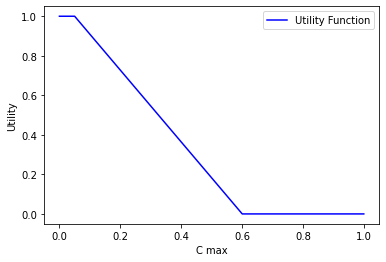

In [9]:
uplot=calc_ufn(Cmax_uplot,Cmax_0u,Cmax_fullu)                                                                                              # Calculate the utility values by calling function
plt.plot(Cmax_uplot,uplot,'b',label='Utility Function')
plt.xlabel('C max')
plt.ylabel('Utility')
plt.legend()
plt.savefig(f"{images_dir}/u fn.png")
plt.show()

Plot base case breakthrough curve at monitoring (sentry) well and at town well (POC)

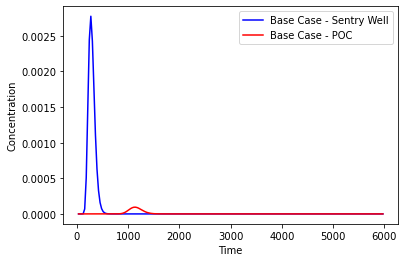

In [10]:
C_base_sentry=calc_btcs(C0, pulse_time, x_obs, R_base, D_base, t_obs, u_base, decay_base)                                                # Base case breakthrough curve (btc) at observation point
C_base_POC=calc_btcs(C0, pulse_time, x_POC, R_base, D_base, t_obs, u_base, decay_base)                                                   # Base case btc at point of compliance (POC)

plt.plot(t_obs,C_base_sentry,'b',label='Base Case - Sentry Well')
plt.plot(t_obs,C_base_POC,'r',label='Base Case - POC')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.savefig(f"{images_dir}/base model BTCs.png")
plt.show()


Calculate stakeholder utility for base conditions\
Based on simple utility function where u = f(Cmax)



In [11]:
u_index = np.nanmax(np.where(Cmax_uplot<=np.nanmax(C_base_POC)))                                                                         # Find index of max C at the POC on the utility vector
util = uplot[u_index]                                                                                                                    # Find the value of the utility at C max at the POC
print('stakeholder utility is ', np.round(util, decimals=2))


stakeholder utility is  1.0


Loop over parameter values to generate an array of many BTCs over parameter limits

In [12]:
P_steps = 5                                                                                                                              # Number of equal parameter steps, including min and max, for each parameter ... generates 4^n realizations
Rstep = (Rmax-Rmin)/(P_steps-1)                                                                                                          # Retardation step
Dstep = (Dmax-Dmin)/(P_steps-1)                                                                                                          # Dispersion step
ustep = (umax-umin)/(P_steps-1)                                                                                                          # Velocity step
decaystep = (decaymax-decaymin)/(P_steps-1)                                                                                              # Decay step

R_vals = np.arange(Rmin, Rmax+Rstep/10/P_steps, Rstep)                                                                                   # Retardation values - note that the +Rstep/10/P adds a point just larger than Rmax to ensure that the series ends at Rmax
D_vals = np.arange(Dmin, Dmax+Dstep/10/P_steps, Dstep)                                                                                   # Dispersion values
u_vals = np.arange(umin, umax+Rstep/10/P_steps, ustep)                                                                                   # Velocity values
decay_vals = np.arange(decaymin, decaymax+decaystep/10/P_steps, decaystep)                                                               # Decay values

C_POC_hold=np.zeros((P_steps**4,len(t_obs)))                                                                                             # Initialize array for breakthrough curves, size is number of realizations by number of observation times
P_hold = np.zeros((P_steps**4,4))                                                                                                        # Initialize array for parameter values, size is number of realizations by number of parameters

icount = -1                                                                                                                              # Initialize counter
for P1 in range(0, P_steps, 1):                                                                                                          # Cycle through parameter values to make all combinations
  for P2 in range(0, P_steps, 1):
    for P3 in range(0, P_steps, 1):
      for P4 in range(0, P_steps, 1):
        P_hold[icount,:] = [R_vals[P1], D_vals[P2], u_vals[P3], R_vals[P4]]                                                              # Store parameter values for later reference
        icount += 1                                                                                                                      # Index counter
        C_POC_hold[icount,:]=calc_btcs(C0, pulse_time, x_POC, R_vals[P1], D_vals[P2], t_obs, u_vals[P3], decay_vals[P4])                 # C(t) at town well - point of compliance
C_POC_hold[np.isnan(C_POC_hold)] = 0                                                                                                     # Replace NaN concentrations with zero - just in case analytical solutions goes awry

Some possibly-useful metrics from the BTC at the town well as the bases for stakeholder utilities

In [13]:
Cmax_hold = np.nanmax(C_POC_hold,1)                                                                                                      # Max concentration for each parameter set (realization)

exceedence_threshold_environment = 1e-05                                                                                                 # Environmental limit - concentration that indicates long-term environmental damage
exceedence_threshold_town = 0.000175                                                                                                     # Municipal limit - concentration that indicates loss of water use for the town

ndays_over_environment = np.sum(C_POC_hold>exceedence_threshold_environment,1)*dt                                                        # Number of days that each BTC exceeds the environmental limit
ndays_over_town = np.sum(C_POC_hold>exceedence_threshold_town,1)*dt                                                                      # Number of days that each BTC exceeds the municipal limit
mass_load_total = np.sum(C_POC_hold,1) * dt * P_hold[:,3] / P_hold[:,1]                                                                  # Approximation of total mass load at the town over duration of each BTC

Factory costs based on BTC at town well

In [14]:
A = 30                                                                                                                                   # Constant to describe size of plant as a function of maximum concentration
B = 0.0001                                                                                                                               # Constant to describe operational costs on a daily basis over life of BTC
C = 1                                                                                                                                    # Constant to describe capital costs on a daily basis over life of BTC - function of mass load per day
D = 15000000                                                                                                                             # Constant to convert relative costs to dollar amount 

infrastructure = A * Cmax_hold * D                                                                                                       # Cost associated with building the factory, in $US
operating_time = B * ndays_over_town  * D                                                                                                # Cost associated with operating the factory - labor/rent/etc, in $US
operating_chems = C * mass_load_total * D                                                                                                # Cost associated with operating the factory - reagents/etc, in $US

cost_factory_components = [infrastructure, operating_time, operating_chems]                                                              # Store the cost components for each realization
cost_factory = infrastructure + operating_time + operating_chems                                                                         # Store the total cost for each realization

Environment utility function based on BTC at town well - constants chosen by environment stakeholder group

In [15]:
A = 0                                                                                                                                    # Constant to describe impacts of short term, higher concentrations
B = 1                                                                                                                                    # Constant to describe impacts of long term, lower concentrations 
C = 80000                                                                                                                                # Constant to describe imapcts of total mass load

env_impact_short = A * ndays_over_town                                                                                                   # Acute costs, not necessarily in $US - just relative
env_impact_long = B * ndays_over_environment                                                                                             # Persistent costs
total_mass = C * mass_load_total                                                                                                         # Total costs

cost_env_components = [env_impact_short, env_impact_long, total_mass]                                                                    # Store the cost components for each realization
cost_env = env_impact_short + env_impact_long + total_mass                                                                               # Store total cost for each realization

cost_floor = 2000                                                                                                                        # Above this 'cost', utilty is zero
cost_ceil = 300                                                                                                                          # Below this 'cost', utility is one
util_env = 1.0 * cost_env                                                                                                                # Create vector to store utilities that is same size as environment 'costs'
util_env[np.where(util_env>=cost_floor)] = cost_floor                                                                                    # Put limits on utility
util_env[np.where(util_env<=cost_ceil)] = cost_ceil
util_env = 1 - (util_env-cost_ceil)/(cost_floor-cost_ceil)                                                                               # Normalize, and utility decreases with increasing concentration


############################################################################################
# BELOW IS OPTIONAL:  PLOTTING FOR ENVIRONMENTAL TEAM TO CHOOSE UTILITY LIMITS AND CONSTANTS
# UNCOMMENT TO RUN
############################################################################################

# x = np.arange(len(cost_env))
# plt.plot(x, env_impact_long,'.r',label='Persistent')
# plt.plot(x, total_mass,'.c',label='Total Mass')
# plt.plot(x, cost_env,'.g',label='Total Cost')
# plt.hlines(2000,0,625,ls='--',color='gray',label="util=0") ## <--- This plots the cost where our utility goes to zero, must be updated manually when cost_floor below changes.
# plt.xlabel('Parameter set number')
# plt.ylabel('Raw cost')
# plt.legend()
# plt.show()
# plt.close()

# total_cost_sort = np.sort(cost_env)
# total_cost_indices = np.argsort(cost_env) 

# # examine breakthrough curves associated with high costs
# num_BTCs = 10

# start_index = np.min(np.where(total_cost_sort>cost_floor))

# print()
# print('Total costs = ', total_cost_sort[start_index:start_index+num_BTCs])
# print()
# toplot = np.squeeze(C_POC_hold[total_cost_indices[start_index:start_index+num_BTCs],:])
# plt.plot(t_obs, toplot.T)
# plt.hlines(exceedence_threshold_environment,0,6000,ls='--',label="env_thresh")
# plt.hlines(exceedence_threshold_town,0,6000,ls='--',color='gray',label="town_thresh")
# plt.xlabel('Time, days')
# plt.ylabel('C at town well')
# plt.legend()
# plt.show()

# # examine breakthrough curves associated with low costs
# num_BTCs = 10

# start_index = np.max(np.where(total_cost_sort<cost_ceil))
# print()
# print('Total costs = ', total_cost_sort[start_index:start_index+num_BTCs])
# print()
# toplot = np.squeeze(C_POC_hold[total_cost_indices[start_index:start_index+num_BTCs],:])
# plt.plot(t_obs, toplot.T)
# plt.hlines(exceedence_threshold_environment,0,6000,ls='--',label="env_thresh")
# plt.hlines(exceedence_threshold_town,0,6000,ls='--',color='gray',label="town_thresh")
# plt.xlabel('Time, days')
# plt.ylabel('C at town well')
# plt.legend()
# plt.show()

# print()
# print('ndays over env C limit range for 0-1 utility = ', np.min(ndays_over_environment[np.where(util_env == 0)]), np.max(ndays_over_environment[np.where(util_env == 1)]))
# print('ndays over town C limit range for 0-1 utility = ', np.min(ndays_over_town[np.where(util_env == 0)]), np.max(ndays_over_town[np.where(util_env == 1)]))

# # show utility curve
# print()
# x = np.arange(len(cost_env))
# plt.plot(x, np.sort(util_env),'.g',label='Utility')
# plt.legend()
# plt.xlabel('Sorted parameter set')
# plt.ylabel('Utility')
# plt.grid()
# plt.show()
# plt.close()

# # examine breakthrough curves above specified utility
# util_check = 0.8      # set a utility value to check BTCs
# num_BTCs = 10

# util_env_sort = np.sort(util_env)
# util_env_indices = np.argsort(util_env) 

# start_index = np.min(np.where(util_env_sort>util_check))
# print()
# print('Utilities = ', util_env_sort[start_index:start_index+num_BTCs])
# print()
# toplot = np.squeeze(C_POC_hold[util_env_indices[start_index:start_index+num_BTCs],:])
# plt.plot(t_obs, toplot.T)
# plt.hlines(exceedence_threshold_environment,0,6000,ls='--',label="env_thresh")
# plt.hlines(exceedence_threshold_town,0,6000,ls='--',color='gray',label="town_thresh")
# plt.xlabel('Time, days')
# plt.ylabel('C at town well')
# plt.grid()
# plt.legend()
# plt.show()

Town utility function based on BTC at town well\
Based on a simple function that only considers two linear periods, short term and long term, and explicitly invokes utility

In [16]:
long_time_threshold = 360                                                                                                                # Number of days that long-term penalty begins           
util_at_ltt = 0.6                                                                                                                        # Utility at the long-term ndays
zerou_time_threshold = 720                                                                                                               # Number of days that utility reaches zero

daily_penalty = (1 - util_at_ltt) / long_time_threshold * ndays_over_town                                                                # Penalty per day up to long-term threshold
long_penalty = util_at_ltt * (ndays_over_town - long_time_threshold) / (zerou_time_threshold  - long_time_threshold)                     # Additional penalty per day after long-term threshold 
util_town = 1 - daily_penalty                                                                                                            # Find total penalty
util_town[np.where(ndays_over_town>long_time_threshold)] -= long_penalty[np.where(ndays_over_town>long_time_threshold)] 
util_town[np.where(util_town < 0)] = 0                                                                                                   # Limit utility between zero and one
util_town[np.where(util_town > 1)] = 1


############################################################################################
# BELOW IS OPTIONAL:  PLOTTING FOR TOWN TEAM TO CHOOSE UTILITY LIMITS AND CONSTANTS
# UNCOMMENT TO RUN
############################################################################################

# plt.plot(np.arange(len(util_town)),np.sort(util_town),'.b')
# plt.xlabel('Sorted Parameter Set Number')
# plt.ylabel('Utility')
# plt.legend()
# plt.show()
# plt.close()


# plt.plot(ndays_over_town,util_town,'.b')
# plt.xlabel('Utility')
# plt.ylabel('Number of Days over Town Limit')
# plt.legend()
# plt.show()
# plt.close()




Regulatory fee structure

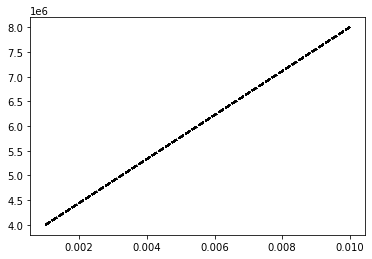

In [17]:
#############################################################
#############################################################
# from regulators
from scipy.stats import linregress

# equation:
def fees(Days_Over, Cmax):
  #adding these lines that establish the slope and intercept to the function to reduce confusion if moved
  point1 = [500, 4000000]
  point2 = [2500, 5000000]
  x_values = [point1[0], point2[0]] 
  y_values = [point1[1], point2[1]]
  slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)
  fees_daysover = slope*Days_Over + intercept

  point1 = [.001, 4000000]
  point2 = [.01, 8000000]
  x_values = [point1[0], point2[0]]
  y_values = [point1[1], point2[1]]
  plt.plot(x_values, y_values, color = 'k', linestyle="--")
  slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values) # getting the equation to determine the fees
  fees_cmax = slope*Cmax+intercept
  return(fees_cmax+fees_daysover)

Fees_Factory = 1* (cost_factory > 4e6)
for i in range(0, len(Cmax_hold)):
  if Cmax_hold[i] < 0.001:
    # print('No Fee')
    Fees_Factory[i] = 0
  else:
    Fees_Factory[i] = fees(ndays_over_town[i], Cmax_hold[i])

############################################################################################
# BELOW IS OPTIONAL:  PLOTTING FOR REGULATOR TEAM TO CHOOSE UTILITY LIMITS AND CONSTANTS
# UNCOMMENT TO RUN
############################################################################################

# x = np.arange(len(util_town))
# plt.plot(x, util_town,'.b',label='Town')
# plt.plot(x, util_env,'.r',label='Environment')
# plt.xlabel('Parameter set number')
# plt.ylabel('Utilities')
# plt.legend()
# plt.show()
# plt.close()

# # choose highest ndays_town with no fee - town utility
# print()
# plt.plot(ndays_over_town, util_town,'.b')
# plt.xlabel('ndays over town limit')
# plt.ylabel('Town utilities')
# plt.show()
# plt.close()

# # choose highest ndays_town with no fee - environment utility
# print()
# plt.plot(ndays_over_town, util_env,'.b')
# plt.xlabel('ndays over town limit')
# plt.ylabel('Environment utilities')
# plt.show()
# plt.close()

# # choose highest ndays_env with no fee - environment utility
# print()
# plt.plot(ndays_over_environment, util_env,'.b')
# plt.xlabel('ndays over environment limit')
# plt.ylabel('Environment utilities')
# plt.show()
# plt.close()

# # choose highest Cmax with no fee - town utility
# print()
# plt.plot(Cmax_hold, util_town,'.b')
# plt.xlabel('Cmax')
# plt.ylabel('Town utilities')
# plt.show()
# plt.close()

# # choose highest Cmax with no fee - environment utility
# print()
# plt.plot(Cmax_hold, util_env,'.b')
# plt.xlabel('Cmax')
# plt.ylabel('Environment utilities')
# plt.show()
# plt.close()

# # correlate factory cost and Cmax above no fee threshold
# Cmax_nofee = 0.002
# print()
# plt.plot(Cmax_hold[np.where(Cmax_hold>Cmax_nofee)], cost_factory[np.where(Cmax_hold>Cmax_nofee)],'.b')
# plt.xlabel('Cmax')
# plt.ylabel('Factory cost')
# plt.show()
# plt.close()

# # correlate factory cost and ndays over town above no fee threshold
# Cmax_nofee = 0.002
# ndays_over_town_nofee = 365
# print()
# plt.plot(ndays_over_town[np.where(ndays_over_town>ndays_over_town_nofee)], cost_factory[np.where(ndays_over_town>ndays_over_town_nofee)],'.b')
# plt.xlabel('number of days over town limit')
# plt.ylabel('Factory cost')
# plt.show()
# plt.close()



Examine trade-offs to choose interesting cases for the Decision Rodeo

In [18]:
############################################################################################
# INSTRUCTOR USE
# UNCOMMENT TO RUN
############################################################################################


# high_env = 1* (util_env > .8)
# low_env = 1* (util_env < .2)
# high_factory = 1* (cost_factory > 4e6)
# low_factory = 1* (cost_factory < 2e6)
# high_town = 1* (util_town > .8)
# low_town = 1* (util_town < .2)

# print()
# plt.plot(util_env, cost_factory,'.k')
# lowlow = np.where(low_env + low_factory >1)
# highhigh = np.where(high_env + high_factory >1)
# lowhigh = np.where(low_env + high_factory > 1)
# highlow = np.where(high_env + low_factory > 1)
# plt.plot(util_env[highhigh], cost_factory[highhigh],'.g')
# plt.plot(util_env[lowlow], cost_factory[lowlow],'.c')
# plt.plot(util_env[lowhigh], cost_factory[lowhigh],'.r')
# plt.plot(util_env[highlow], cost_factory[highlow],'.b')
# plt.xlabel('Environmental Utility')
# plt.ylabel('Factory Cost')
# plt.show()
# plt.close()

# print()
# plt.plot(util_town, cost_factory,'.k')
# lowlow = np.where(low_town + low_factory >1)
# highhigh = np.where(high_town + high_factory >1)
# lowhigh = np.where(low_town + high_factory > 1)
# highlow = np.where(high_town + low_factory > 1)
# plt.plot(util_town[highhigh], cost_factory[highhigh],'.g')
# plt.plot(util_town[lowlow], cost_factory[lowlow],'.c')
# plt.plot(util_town[lowhigh], cost_factory[lowhigh],'.r')
# plt.plot(util_town[highlow], cost_factory[highlow],'.b')
# plt.xlabel('Town Utility')
# plt.ylabel('Factory Cost')
# plt.show()
# plt.close()

# print()
# plt.plot(util_env, util_town,'.b')
# plt.xlabel('Environmental Utility')
# plt.ylabel('Town Utility')
# plt.show()
# plt.close()

# # cases

# # low factory cost, low env utility, low town utility
# # print(np.where(low_factory+low_env + low_town == 3))
# # print(util_town[np.where(low_factory+low_env + low_town == 3)])
# print('parameter set 81')
# print('factory cost', int(cost_factory[81]))
# print('env utility', np.round(util_env[81],2))
# print('town utility', np.round(util_town[81],2))
# print('noncompliance fee', int(Fees_Factory[81]))
# print()

# # low factory cost, high env utility, high town utility
# # print(np.where(low_factory+high_env + high_town == 3))
# # print(util_town[np.where(low_factory+high_env + high_town == 3)])
# print('parameter set 526')
# print('factory cost', int(cost_factory[526]))
# print('env utility', np.round(util_env[526],2))
# print('town utility', np.round(util_town[526],2))
# print('noncompliance fee', int(Fees_Factory[526]))
# print()

# # high factory cost, low env utility, not low town utility
# # print(np.where(high_factory+low_env == 2))
# # print(util_town[np.where(high_factory+low_env == 2)])
# print('parameter set 15')
# print('factory cost', int(cost_factory[15]))
# print('env utility', np.round(util_env[15],2))
# print('town utility', np.round(util_town[15],2))
# print('noncompliance fee', int(Fees_Factory[15]))
# print()

# # intermed factory cost, intermed env utility, intermed town utility
# temp1 = np.squeeze(np.where(low_env + high_env + low_town+ high_town == 0))
# temp2 = cost_factory[temp1]
# # print(temp1)
# # print(temp2)
# # print(temp1[np.where(temp2 == np.min(temp2))])
# print('parameter set 112')
# print('factory cost', int(cost_factory[112]))
# print('env utility', np.round(util_env[112],2))
# print('town utility', np.round(util_town[112],2))
# print('noncompliance fee', int(Fees_Factory[112]))
# print()

# # intermed factory cost, intermed env utility, intermed town utility
# temp1 = np.squeeze(np.where(low_env + high_env + low_town+ high_town == 0))
# temp2 = cost_factory[temp1]
# # print(temp1)
# # print(temp2)
# # print(temp1[np.where(temp2 == np.max(temp2))])
# print('parameter set 71')
# print('factory cost', int(cost_factory[71]))
# print('env utility', np.round(util_env[71],2))
# print('town utility', np.round(util_town[71],2))
# print('noncompliance fee', int(Fees_Factory[71]))
# print()




Results to view for Decision Rodeo I

In [19]:
############################################################################################
# INSTRUCTOR USE
# UNCOMMENT TO RUN
############################################################################################


# pview = [81, 526, 15, 112, 71]
# for i in pview:
#   print()
#   plt.plot(t_obs, C_POC_hold[i,:],'.b')
#   plt.xlabel('Time')
#   plt.ylabel('C at Town Well')
#   plt.show()
#   plt.close()
#   print('set = ', i, '    R = ', P_hold[i,0], '    D = ', P_hold[i,1], '    velocity = ', P_hold[i,2], '    decay = ', P_hold[i,3] )
#   print('factory cost', int(cost_factory[i]))
#   print('env utility', np.round(util_env[i],2))
#   print('town utility', np.round(util_town[i],2))
#   print('noncompliance fee', int(Fees_Factory[i]))

Practice fitting a model to noise-free data


R range [ 1  -  2  ].  Previous R =  1.0

D range [ 10  -  100  ].  Previous R =  10.0

velocity range [ 1  -  3  ].  Previous R =  1.0

decay range [ 0.0  -  0.005  ].  Previous R =  0.0


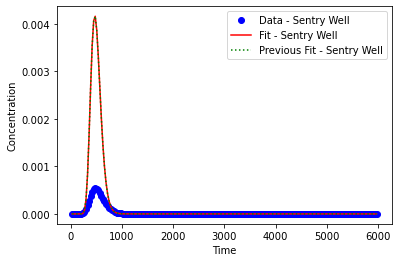

In [21]:
# as a reminder, the hydrologic parameter ranges are
# Rmin = 1                                                                                                                                   # minimum retardation []
# Rmax = 2                                                                                                                                   # maximum retardation []
# Dmin = 10                                                                                                                                  # minimum dispersion [L/T2]
# Dmax = 100                                                                                                                                 # maximum dispersion [L/T2
# umin = 1                                                                                                                                   # minimum velocity [L/T]
# umax = 3                                                                                                                                   # maximum velocity [L/T]
# decaymin = 0.000                                                                                                                           # minimum decay [/T]
# decaymax = 0.005                                                                                                                           # maximum decay [/T]

# generate data to fit
newdata = int(input("Enter 1 to generate new data, 0 to continue fitting data  "))
if newdata == 1:
  R_data = np.random.rand(1,1) * (Rmax - Rmin) + Rmin
  D_data = np.random.rand(1,1) * (Dmax - Dmin) + Dmin
  u_data = np.random.rand(1,1) * (umax - umin) + umin
  decay_data = np.random.rand(1,1) * (decaymax - decaymin) + decaymin
  C_data_sentry = calc_btcs(C0, pulse_time, x_obs, R_data, D_data, t_obs, u_data, decay_data)                                                # base case btc at observation point
# store some initial 'previous guess' parameter values
  prev_R_fit = 1.
  prev_D_fit = 10.
  prev_u_fit = 1.
  prev_decay_fit = 0.000

# Follow prompts to change the parameter values to fit the curve (line) to the data (points)
print()
print("R range [", Rmin, " - ", Rmax," ].  Previous R = ",prev_R_fit)
R_fit = input("Suggest a new value and enter or just press enter to keep old value  ")
if R_fit == "":
  R_fit = prev_R_fit
else:
  R_fit = float(R_fit)
  if R_fit < Rmin:
    R_fit = Rmin
  elif R_fit > Rmax:
    R_fit = Rmax

print()
print("D range [", Dmin, " - ", Dmax," ].  Previous R = ",prev_D_fit)
D_fit = input("Suggest a new value and enter or just press enter to keep old value  ")
if D_fit == "":
  D_fit = prev_D_fit
else:
  D_fit = float(D_fit)
  if D_fit < Dmin:
    D_fit = Dmin
  elif D_fit > Dmax:
    D_fit = Dmax

print()
print("velocity range [", umin, " - ", umax," ].  Previous R = ",prev_u_fit)
u_fit = input("Suggest a new value and enter or just press enter to keep old value  ")
if u_fit == "":
  u_fit = prev_u_fit
else:
  u_fit = float(u_fit)
  if u_fit < umin:
    u_fit = umin
  elif u_fit > umax:
    u_fit = umax

print()
print("decay range [", decaymin, " - ", decaymax," ].  Previous R = ",prev_decay_fit)

decay_fit = input("Suggest a new value and enter or just press enter to keep old value  ")
if decay_fit == "":
  decay_fit = prev_decay_fit
else:
  decay_fit = float(decay_fit)
  if decay_fit < decaymin:
    decay_fit = decaymin
  elif decay_fit > decaymax:
    decay_fit = decaymax

C_fit_sentry=calc_btcs(C0, pulse_time, x_obs, R_fit, D_fit, t_obs, u_fit, decay_fit)                                                   # base case btc at point of compliance
C_prev_fit_sentry=calc_btcs(C0, pulse_time, x_obs, prev_R_fit, prev_D_fit, t_obs, prev_u_fit, prev_decay_fit)                                                   # base case btc at point of compliance
plt.plot(t_obs,np.squeeze(C_data_sentry),'ob',label='Data - Sentry Well')
plt.plot(t_obs,np.squeeze(C_fit_sentry),'r',label='Fit - Sentry Well')
plt.plot(t_obs,np.squeeze(C_prev_fit_sentry),'g:',label='Previous Fit - Sentry Well')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.savefig(f"{images_dir}/base model BTCs.png")
plt.show()

prev_R_fit = 1.0 * R_fit
prev_D_fit = 1.0 * D_fit
prev_u_fit = 1.0 * u_fit
prev_decay_fit = 1.0 * decay_fit



Generate data for fitting HW

[[1.06804176e+00 1.18308043e+01 2.50239129e+00 3.56888006e-03]
 [1.99017899e+00 3.59427068e+01 2.35100601e+00 1.02302417e-03]
 [1.38681297e+00 3.98990895e+01 1.02401997e+00 2.16485528e-04]
 [1.29412267e+00 4.24614590e+01 1.10790307e+00 2.43945160e-03]
 [1.15734172e+00 4.77921638e+01 1.60544607e+00 3.51999452e-03]]


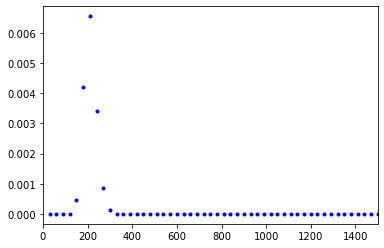

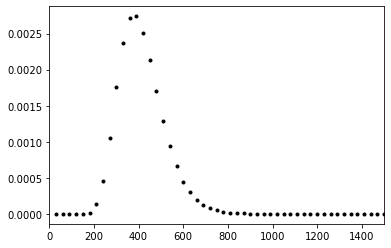

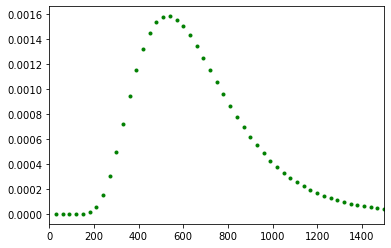

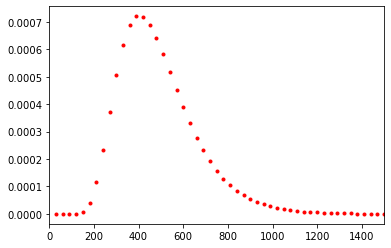

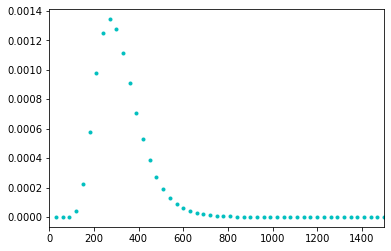

[[1.06804176e+00 1.18308043e+01 2.50239129e+00 3.56888006e-03]
 [1.99017899e+00 3.59427068e+01 2.35100601e+00 1.02302417e-03]
 [1.38681297e+00 3.98990895e+01 1.02401997e+00 2.16485528e-04]
 [1.29412267e+00 4.24614590e+01 1.10790307e+00 2.43945160e-03]
 [1.15734172e+00 4.77921638e+01 1.60544607e+00 3.51999452e-03]]


In [23]:
################################################################################################
# Ty will use the following to generate C(time) data at the monitoring well for you to interpret
################################################################################################

HW_params = np.random.rand(5,4)
HW_params[:,0] = HW_params[:,0] * (Rmax - Rmin) + Rmin
HW_params[:,1] = HW_params[:,1] * (Dmax - Dmin) + Dmin
HW_params[:,2] = HW_params[:,2] * (umax - umin) + umin
HW_params[:,3] = HW_params[:,3] * (decaymax - decaymin) + decaymin

print(HW_params)

save_obs_data = C_POC_hold[0:5,:] * 0.0
save_POC_data = C_POC_hold[0:5,:] * 0.0

colorstrng = 'bkgrc'
for i in np.arange(5):
  save_obs_data[i,:] = calc_btcs(C0, pulse_time, x_obs, HW_params[i,0], HW_params[i,1], t_obs, HW_params[i,2], HW_params[i,3])
  save_POC_data[i,:] = calc_btcs(C0, pulse_time, x_POC, HW_params[i,0], HW_params[i,1], t_obs, HW_params[i,2], HW_params[i,3])
  symb = colorstrng[i] + '.'
  plt.plot(t_obs,save_obs_data[i,:],symb,label='Data - Sentry Well')
  plt.xlim(0,1500)
  plt.show()

print(HW_params)

prev_fit_params = HW_params * 0.
prev_fit_params[0,:] = [1, 10, 1, 0.000]
prev_fit_params[1,:] = [1, 10, 1, 0.000]
prev_fit_params[2,:] = [1, 10, 1, 0.000]
prev_fit_params[3,:] = [1, 10, 1, 0.000]
prev_fit_params[4,:] = [1, 10, 1, 0.000]


Data fitting, no error, homework  

*   Ty will provide the obs_fit data so that you don't know the parameter values


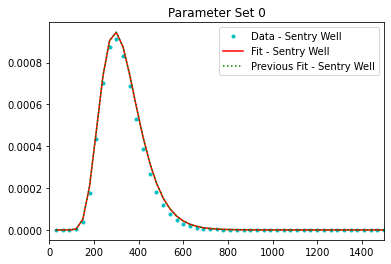

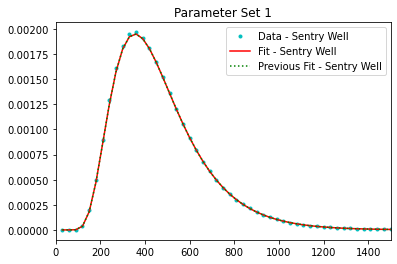

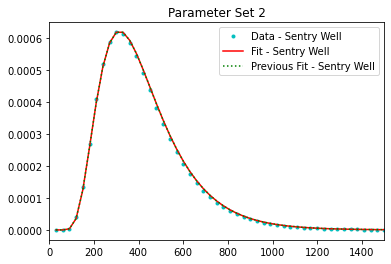

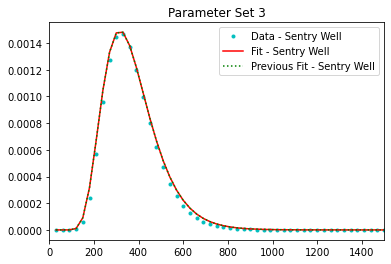

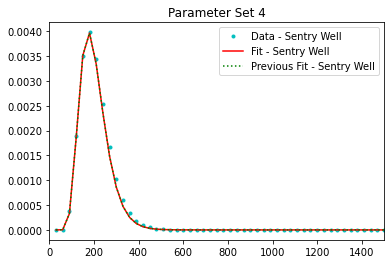

In [302]:
# as a reminder, the hydrologic parameter ranges are
# Rmin = 1                                                                                                                                   # minimum retardation []
# Rmax = 2                                                                                                                                   # maximum retardation []
# Dmin = 10                                                                                                                                  # minimum dispersion [L/T2]
# Dmax = 100                                                                                                                                 # maximum dispersion [L/T2
# umin = 1                                                                                                                                   # minimum velocity [L/T]
# umax = 3                                                                                                                                   # maximum velocity [L/T]
# decaymin = 0.000                                                                                                                           # minimum decay [/T]
# decaymax = 0.005                                                                                                                           # maximum decay [/T]

################################################################################
# To do the homework
#      download the file HW_BTCs.npy from Slack into your Google Drive
#      uncomment the following line, make sure to edit the directory structure to match yours
#      once you run this block, you will generate the data to fit
#      once you have fit the five breakthrough curves, you can use the Google Form to report them
#
#      Good luck!  (Especially you, Mica. I'm watching!!)
################################################################################
save_obs_data = np.load("HW_BTCs.npy")

fit_params = HW_params * 0.

fit_params[0,:] = [2.8, 88, 3.65, 0.0044]
fit_params[1,:] = [1.305, 65, 1.34, 0.00047]
fit_params[2,:] = [1.011, 60, 0.85, 0.00293]
fit_params[3,:] = [1.03, 38, 1.25, 0.0023]
fit_params[4,:] = [1.003, 60, 2.35, 0.0028]

for i in np.arange(5):

  obs_fit = calc_btcs(C0, pulse_time, x_obs, fit_params[i,0], fit_params[i,1], t_obs, fit_params[i,2], fit_params[i,3])
  obs_prev_fit = calc_btcs(C0, pulse_time, x_obs, prev_fit_params[i,0], fit_params[i,1], t_obs, fit_params[i,2], fit_params[i,3])
  plt.plot(t_obs,save_obs_data[i,:],symb,label='Data - Sentry Well')
  plt.plot(t_obs,obs_fit,'r',label='Fit - Sentry Well')
  plt.plot(t_obs,obs_prev_fit,'g:',label='Previous Fit - Sentry Well')
  plt.title('Parameter Set {}'.format(i))
  plt.xlim(0,1500)
  plt.legend()
  plt.savefig('images_dir/paramSet-{}'.format(i))
  plt.show()
prev_fit_params = 1.0 * fit_params

Responses at town well - use this to see the ramifications of your misfits - not required, just for interest

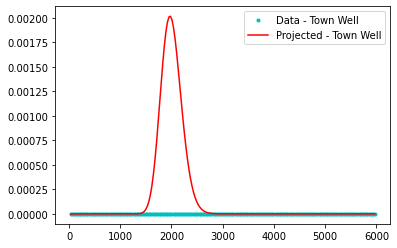

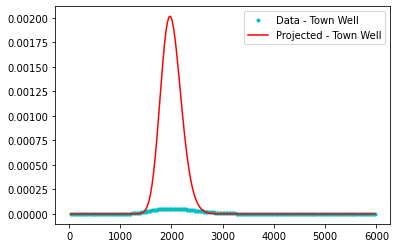

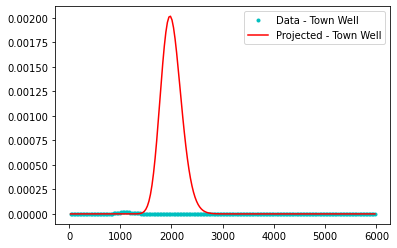

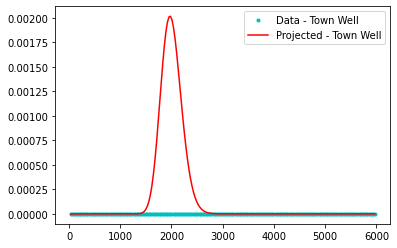

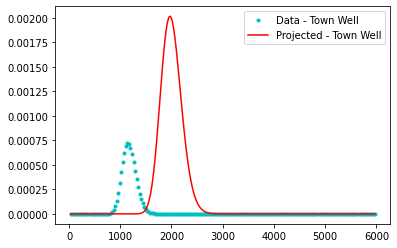

In [ ]:
for i in np.arange(5):
  POC_fit = calc_btcs(C0, pulse_time, x_POC, fit_params[i,0], fit_params[i,1], t_obs, fit_params[i,2], fit_params[i,3])
  plt.plot(t_obs,save_POC_data[i,:],symb,label='Data - Town Well')
  plt.plot(t_obs,POC_fit,'r',label='Projected - Town Well')
  # plt.xlim(0,1500)
  plt.legend()
  plt.show()
